In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from resources.plotting import Plotter
from tqdm.autonotebook import tqdm

from nltk.tokenize import WordPunctTokenizer

from nltk.translate.bleu_score import sentence_bleu
from rouge_score.rouge_scorer import RougeScorer
from resources.bart_score import BARTScorer
from resources.auc_score import AUCScorer
from resources.testing import PearsonCorrelationTester
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
MODELS = {
    "Gemma 1.1 - 2B": "google/gemma-1.1-2b-it",
    "Gemma 1.1 - 7B": "google/gemma-1.1-7b-it",
    "Gemma 2.0 - 9B": "google/gemma-2-9b-it",
    "Llama 3.1 - 8B": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "Llama 3.2 - 1B": "meta-llama/Llama-3.2-1B-Instruct",
    "Llama 3.2 - 3B": "meta-llama/Llama-3.2-3B-Instruct",
    "Falcon 1.0 - 7B": "tiiuae/Falcon-7B-Instruct",
    "Falcon 3.0 - 3B": "tiiuae/Falcon3-3B-Instruct",
    "Falcon 3.0 - 7B": "tiiuae/Falcon3-7B-Instruct",
    "Falcon 3.0 - 10B": "tiiuae/Falcon3-10B-Instruct"
}
LABELS = np.array(['insult', 'identity based attack', 'profane/obscene', 'threat'], dtype=object)

PLOTS_DIR  = "plots"

# Load results:

In [3]:
RESULTS = {}

for key in MODELS:
    t_start = time.time()
    with open(f'results/toxic spans/{MODELS[key]}.pkl', 'rb') as file:
        RESULTS[key] = pickle.load(file)
    print(f'Loaded {key} ({len(RESULTS[key]):d} instances, dt={(time.time()-t_start)*1000:.2f} ms).')

Loaded Gemma 1.1 - 2B (200 instances, dt=837.66 ms).
Loaded Gemma 1.1 - 7B (200 instances, dt=1308.06 ms).
Loaded Gemma 2.0 - 9B (200 instances, dt=1273.26 ms).
Loaded Llama 3.1 - 8B (200 instances, dt=1194.94 ms).
Loaded Llama 3.2 - 1B (200 instances, dt=1186.42 ms).
Loaded Llama 3.2 - 3B (200 instances, dt=1226.95 ms).
Loaded Falcon 1.0 - 7B (200 instances, dt=1288.97 ms).
Loaded Falcon 3.0 - 3B (200 instances, dt=1268.26 ms).
Loaded Falcon 3.0 - 7B (200 instances, dt=895.44 ms).
Loaded Falcon 3.0 - 10B (200 instances, dt=1257.27 ms).


In [4]:
pearson = PearsonCorrelationTester()
plotter = Plotter(RESULTS, i_sample=8, save_dir=PLOTS_DIR)
plotter = Plotter(RESULTS, save_dir=PLOTS_DIR)
scorer  = AUCScorer(RESULTS)
plotter.print_chat("Llama 3.1 - 8B")

\begin{tabular}{p{.05\linewidth}p{.1\linewidth}p{.8\linewidth}}

\hline

&
\textbf{user}: &
\texttt{What kind of toxic language is present in the following post?

"Hey Sheep the Trump Hotel (disaster) is up for sale.  You interested? You moron."

Assign one of the following labels: "insult", "identity based attack", "profane/obscene", or "threat". Make sure to answer only with the label or "none" if none of them applies.} \\

&
\textbf{assistant}: &
\texttt{insult} \\


\hline

&
\textbf{user}: &
\texttt{What is the most important phrase of the post influencing your assessment? Provide only the phrase as a string.} \\

&
\textbf{assistant}: &
\texttt{"You moron"} \\


\hline

&
\textbf{user}: &
\texttt{Provide a version of the post that would alter your assessment to "identity based attack" while changing as few words in the original post as possible. Make sure to only answer with the changed post.} \\

&
\textbf{assistant}: &
\texttt{"Hey Trump supporter the Trump Hotel (disaster) is 

# Performance:

In [5]:
for model in RESULTS:
    y_true = np.array([''.join(item['label']['tokens']) for item in RESULTS[model]])
    y_pred = np.array([''.join(item['prediction']['text']) for item in RESULTS[model]])

    ls = np.unique(y_true)
    y_true = np.array([y_true == l for l in ls]).T
    y_pred = np.array([y_pred == l for l in ls]).T
    
    print(model)
    print(f'  F1:           {f1_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  precision:    {precision_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  recall:       {recall_score(y_true, y_pred, average="macro"):.2f}')
    print()

Gemma 1.1 - 2B
  F1:           0.00
  precision:    0.00
  recall:       0.00

Gemma 1.1 - 7B
  F1:           0.24
  precision:    0.53
  recall:       0.20

Gemma 2.0 - 9B
  F1:           0.27
  precision:    0.53
  recall:       0.27

Llama 3.1 - 8B
  F1:           0.27
  precision:    0.52
  recall:       0.30

Llama 3.2 - 1B
  F1:           0.08
  precision:    0.06
  recall:       0.12

Llama 3.2 - 3B
  F1:           0.06
  precision:    0.32
  recall:       0.04

Falcon 1.0 - 7B
  F1:           0.06
  precision:    0.05
  recall:       0.10

Falcon 3.0 - 3B
  F1:           0.01
  precision:    0.06
  recall:       0.01

Falcon 3.0 - 7B
  F1:           0.24
  precision:    0.26
  recall:       0.24

Falcon 3.0 - 10B
  F1:           0.34
  precision:    0.53
  recall:       0.33



/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/

# Faithfullness:

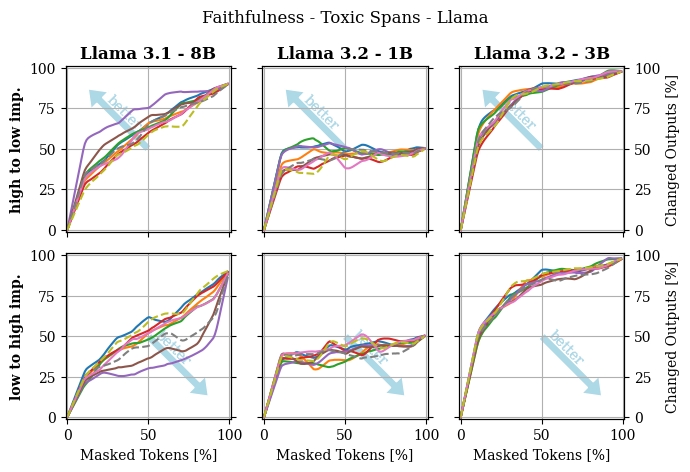

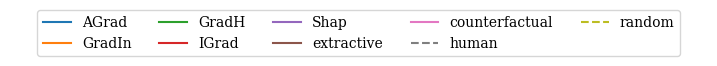

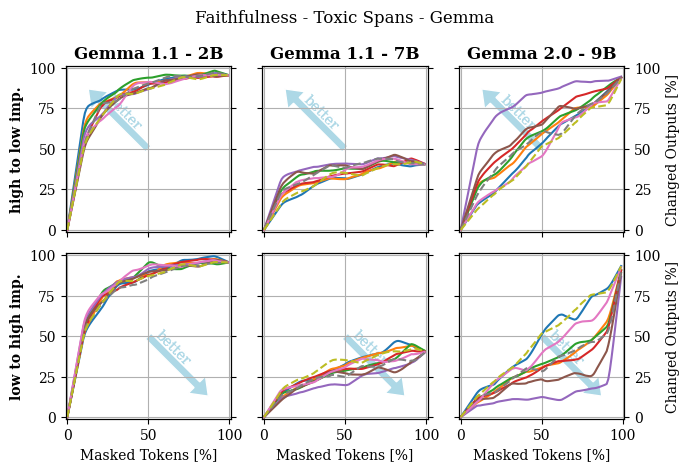

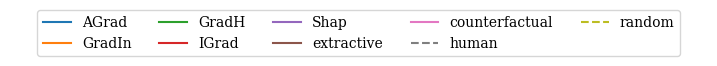

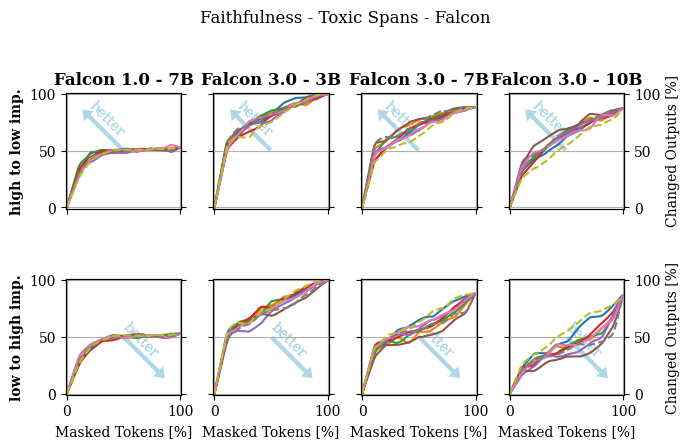

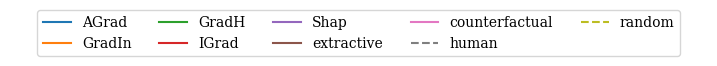

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & Gemma 1.1 - 2B & Gemma 1.1 - 7B & Gemma 2.0 - 9B & Llama 3.1 - 8B & Llama 3.2 - 1B & Llama 3.2 - 3B & Falcon 1.0 - 7B & Falcon 3.0 - 3B & Falcon 3.0 - 7B & Falcon 3.0 - 10B \\
\midrule
AGrad & 0.04 & -0.01 & 0.04 & 0.06 & 0.07 & 0.04 & 0.02 & 0.05 & 0.06 & 0.09 \\
GradIn & 0.02 & 0.02 & 0.23 & 0.09 & 0.07 & 0.04 & 0.00 & 0.03 & 0.17 & 0.19 \\
GradH & 0.03 & 0.08 & 0.24 & 0.12 & 0.11 & 0.03 & 0.02 & 0.04 & 0.13 & 0.19 \\
IGrad & 0.00 & 0.05 & 0.31 & 0.04 & 0.00 & -0.00 & 0.02 & 0.00 & 0.09 & 0.16 \\
Shap & -0.01 & 0.16 & 0.62 & 0.39 & 0.09 & 0.02 & -0.01 & 0.06 & 0.08 & 0.24 \\
human & 0.03 & 0.10 & 0.22 & 0.16 & 0.05 & 0.04 & 0.00 & 0.08 & 0.15 & 0.23 \\
extractive & -0.01 & 0.12 & 0.37 & 0.25 & 0.03 & 0.04 & -0.00 & 0.09 & 0.21 & 0.31 \\
counterfactual & -0.03 & 0.06 & 0.08 & 0.09 & -0.01 & 0.04 & 0.00 & 0.05 & 0.06 & 0.18 \\
\bottomrule
\end{tabular}



In [6]:
plotter.plot_perturbation('Faithfulness - Toxic Spans')
print(scorer.score_table().to_latex(formatters={"name": str.upper},  float_format="{:.2f}".format))

Gemma 1.1 - 2B

In [7]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 1.1 - 2B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['identity based attack<eos>', '8'],
       ['the provided post contains **"identity based attack', '1216'],
       ['the provided post contains **identity based attack**. the',
        '176'],
       ['the provided text contains a combination of "insult', '16'],
       ['the provided text contains insults, identity-based attacks',
        '40'],
       ['the provided text exhibits **identity based attack**. it', '8'],
       ['the provided text exhibits **identity based attack**. the',
        '96'],
       ['the provided text exhibits both "identity based attack', '40']],
      dtype='<U58')

Gemma 1.1 - 7B

In [8]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 1.1 - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['identity based attack', '64'],
       ['identity based attack**<eos>', '40'],
       ['identity based attack<eos>', '1496']], dtype='<U28')

Gemma 2.0 - 9B

In [9]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 2.0 - 9B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['none \n<end_of_turn><eos>', '1600']], dtype='<U24')

Llama 3.1 - 8B

In [10]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.1 - 8B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['none<|eot_id|>', '1600']], dtype='<U21')

Llama 3.2 - 1B

In [11]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.2 - 1B"] for key in r['perturbation']],
    return_counts=True
)).T

array([["I can't fulfill this request.<|eot_id|>", '8'],
       ['Threat<|eot_id|>', '928'],
       ['identity based attack<|eot_id|>', '440'],
       ['none<|eot_id|>', '224']], dtype='<U39')

Llama 3.2 - 3B

In [12]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.2 - 3B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['"none"<|eot_id|>', '376'],
       ["I don't see any text in the provided post", '40'],
       ["I'm happy to help you with your question!", '16'],
       ["I'm happy to help you, but I don", '8'],
       ["I'm happy to help you, but I have", '8'],
       ["I'm happy to help you, but it seems", '128'],
       ["I'm ready to help. However, I don", '192'],
       ["I'm unable to identify the content of the post", '8'],
       ["I'm unable to identify the toxic language in the", '8'],
       ['There is no text in the provided post for me', '8'],
       ['There is no text in the provided post, only', '32'],
       ['There is no text in the provided post, so', '32'],
       ['There is no toxic language present in the provided post', '40'],
       ["Without the actual text of the post, I'm", '32'],
       ['none<|eot_id|>', '672']], dtype='<U55')

Falcon 1.0 - 7B

In [13]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Falcon 1.0 - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['"I\'s a good idea to use a', '8'],
       ['"None of the above."\nUser <|endoftext|>', '24'],
       ['"None"\nUser <|endoftext|>', '16'],
       ['"insult"\nUser <|endoftext|>', '1552']], dtype='<U39')

Falcon 3.0 - 3B

In [14]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Falcon 3.0 - 3B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['The provided text "###############', '280'],
       ['The provided text "############..."', '8'],
       ['The provided text does not contain any identifiable language that',
        '72'],
       ['The provided text does not contain any of the specified', '592'],
       ['The provided text does not contain any recognizable pattern of',
        '136'],
       ['The provided text does not contain any recognizable pattern or',
        '40'],
       ['The provided text does not contain any recognizable toxic language',
        '392'],
       ['The text provided contains a large number of "#', '8'],
       ['The text provided contains multiple hashtags (###)', '40'],
       ['The text provided contains multiple instances of the hashtag ',
        '16'],
       ['The text provided contains profane language, specifically "',
        '8'],
       ['none<|endoftext|>', '8']], dtype='<U66')

Falcon 3.0 - 7B

In [15]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Falcon 3.0 - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['none<|endoftext|>', '1600']], dtype='<U21')

Falcon 3.0 - 10B

In [16]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Falcon 3.0 - 10B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['none<|endoftext|>', '1600']], dtype='<U21')

# Self assessment:

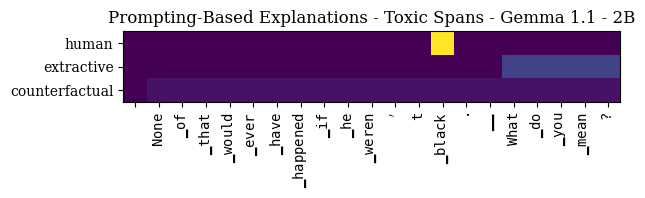

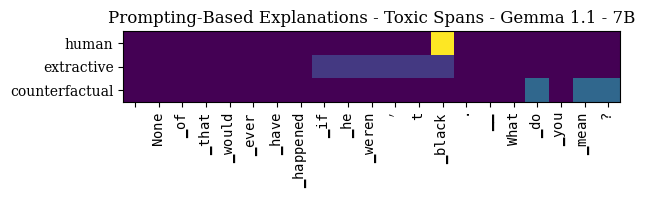

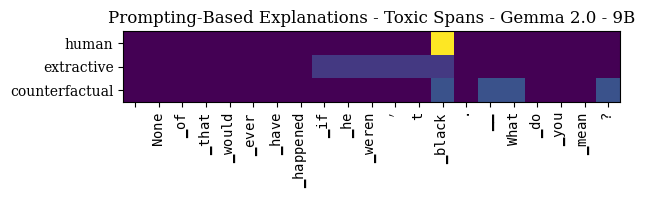

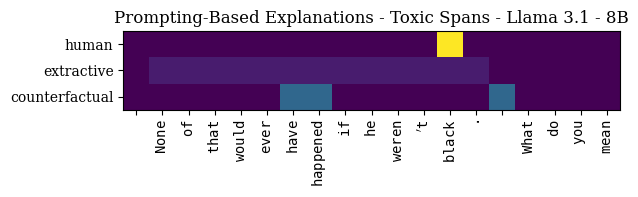

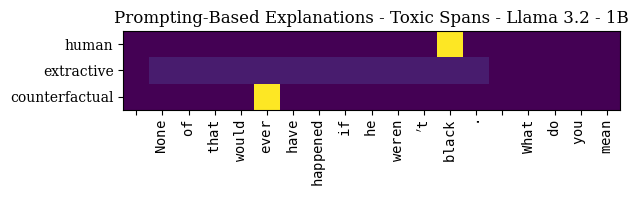

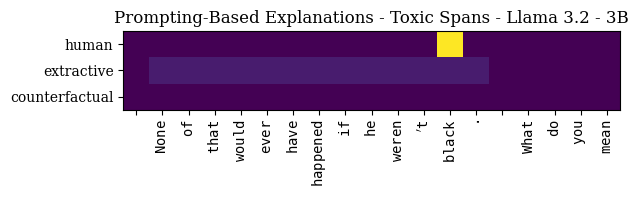

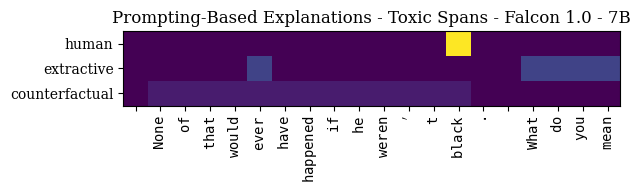

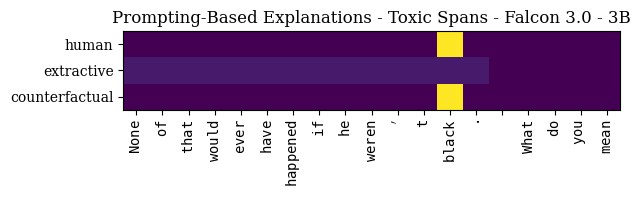

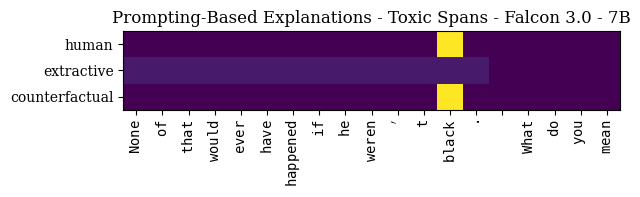

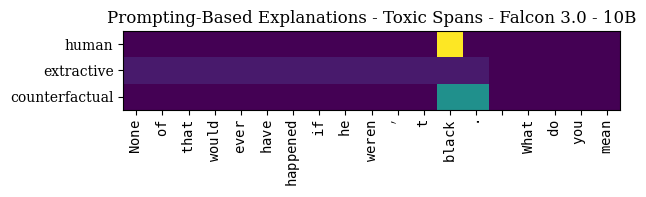

In [17]:
importance_human = {model:[] for model in RESULTS}
importance_self  = {model:[] for model in RESULTS}
importance_cf    = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']
        
        importance_human[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['human']: 
            importance_human[model][-1][i-offset:j-offset] = 1.
        importance_human[model][-1] /= max(importance_human[model][-1].sum(), 1e-9)
        
        importance_self[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['extractive']:
            importance_self[model][-1][i-offset:j-offset] = 1.
        importance_self[model][-1] /= max(importance_self[model][-1].sum(), 1e-9)
        
        importance_cf[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['counterfactual']:
            importance_cf[model][-1][i-offset:j-offset] = 1.
        importance_cf[model][-1] /= max(importance_cf[model][-1].sum(), 1e-9)

plotter.plot_importance([importance_human, importance_self, importance_cf], ['human', 'extractive', 'counterfactual'], f'Prompting-Based Explanations - Toxic Spans')
pearson.add(importance_human, 'human')
pearson.add(importance_self,  'extractive')
pearson.add(importance_cf,    'counterfactual')

# AGrad:

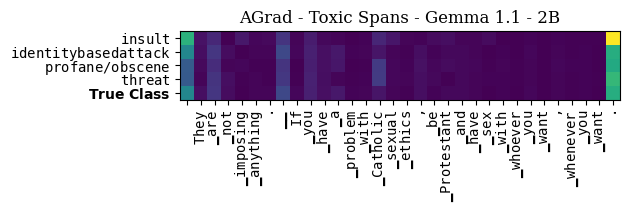

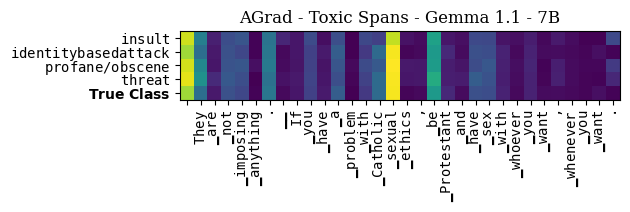

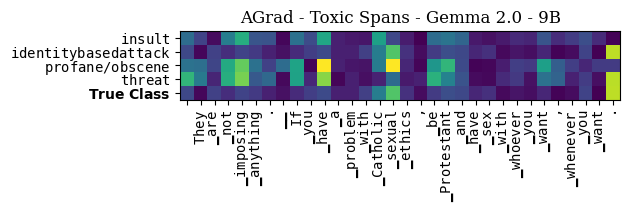

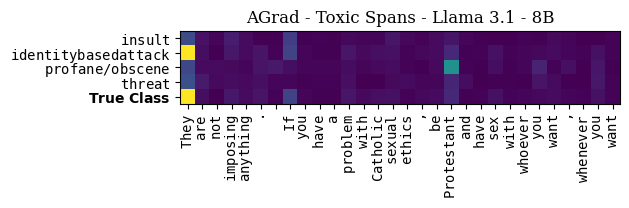

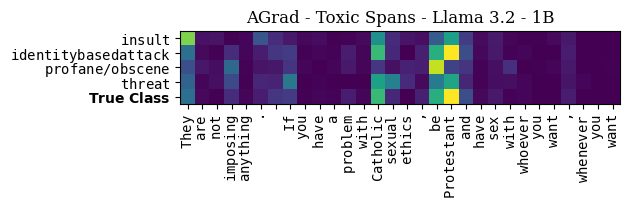

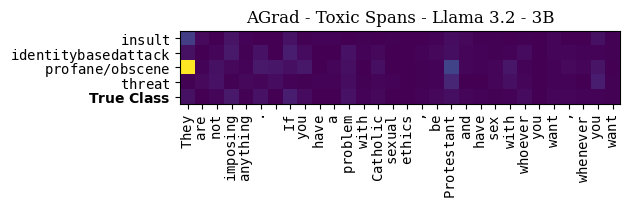

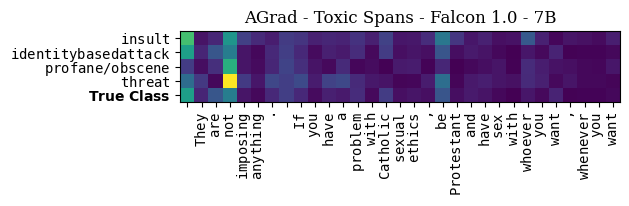

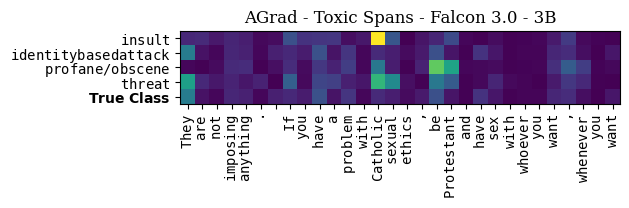

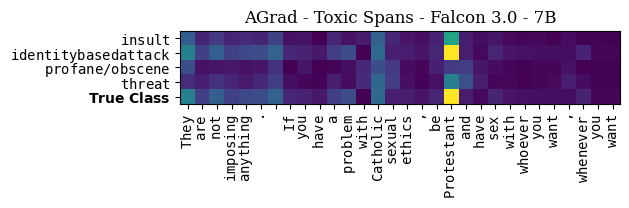

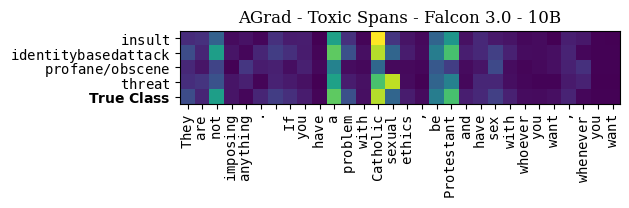

In [18]:
importance_agrad_raw = {model:[] for model in RESULTS}
importance_agrad_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']

        # get importance:
        importance = np.abs(r['AGrad'][:, :, x_start:x_end].mean(axis=0))

        # per token in label:
        importance_agrad_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_agrad_cls[model].append(importance_agrad_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_agrad_raw, importance_agrad_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'AGrad - Toxic Spans')
pearson.add(importance_agrad_cls, 'AGrad')

# GradIn

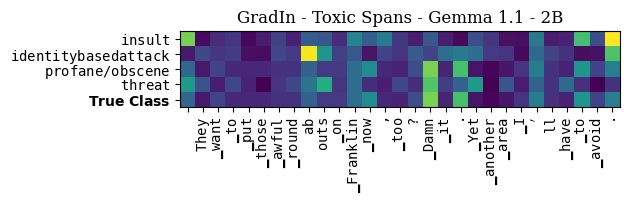

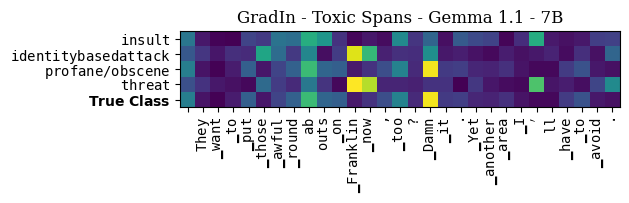

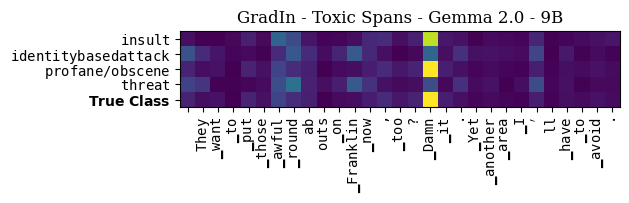

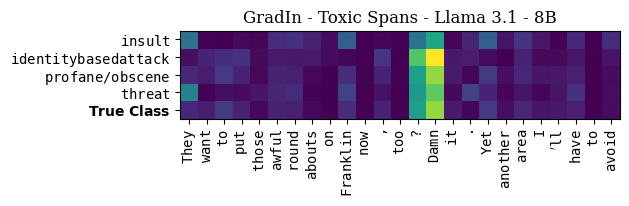

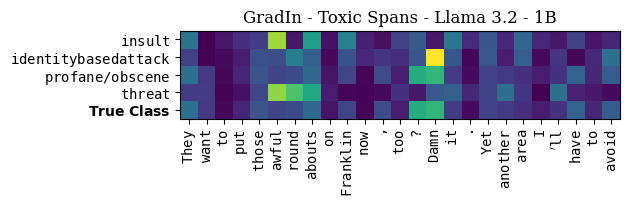

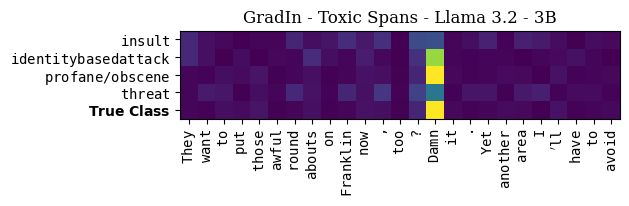

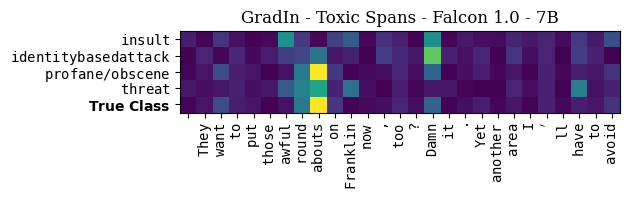

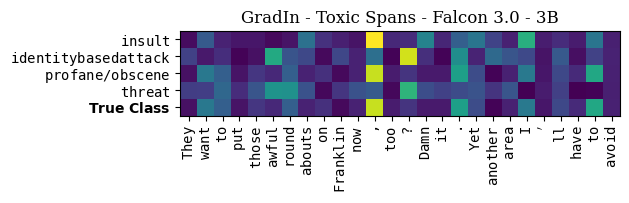

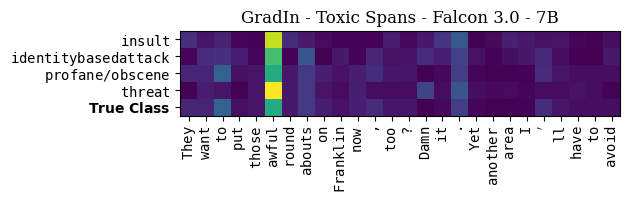

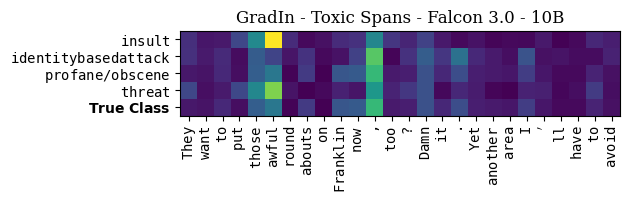

In [19]:
importance_gradin_raw = {model:[] for model in RESULTS}
importance_gradin_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']
    
        # get importance:
        importance = np.abs(r['GradIn'][:, start:end])
    
        # per token in label:
        importance_gradin_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_gradin_cls[model].append(importance_gradin_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_gradin_raw, importance_gradin_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'GradIn - Toxic Spans')
pearson.add(importance_gradin_cls, 'GradIn')

# GradH

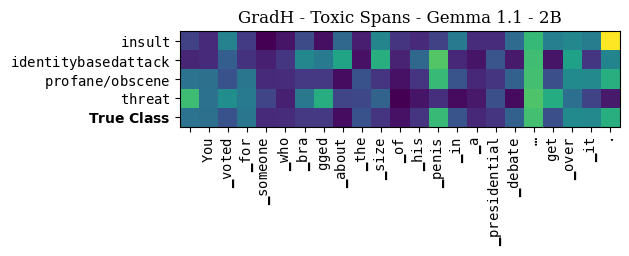

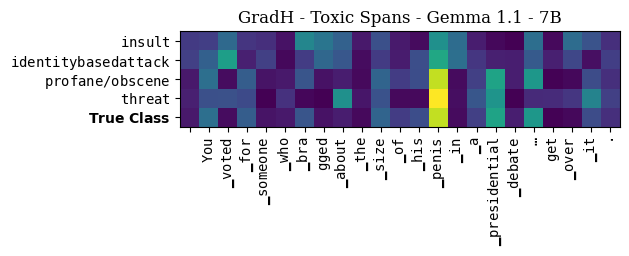

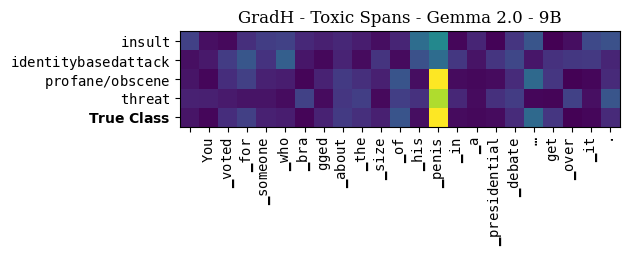

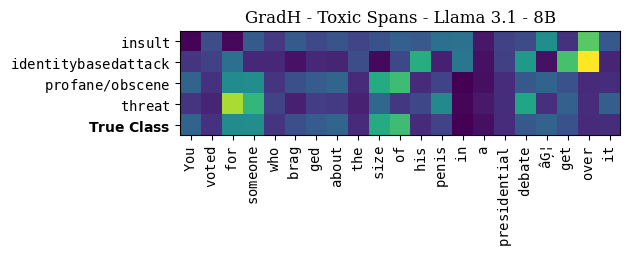

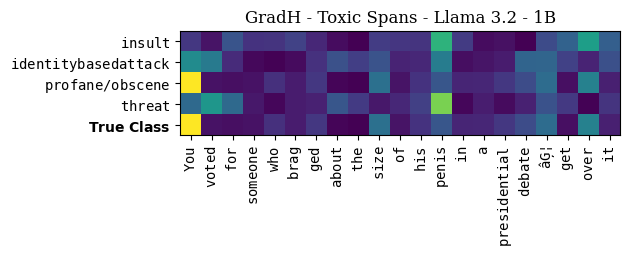

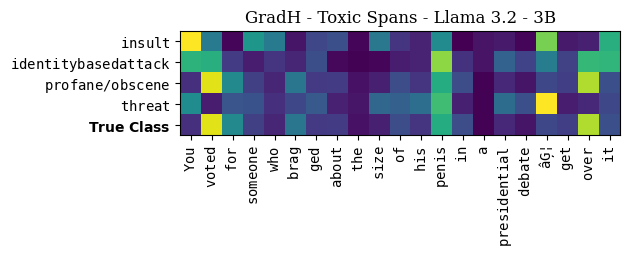

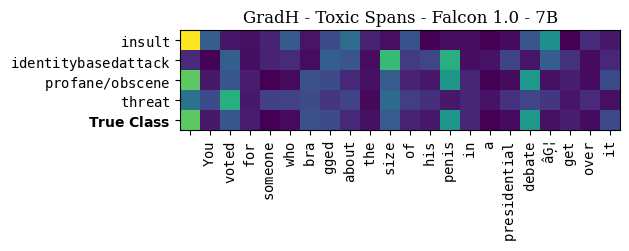

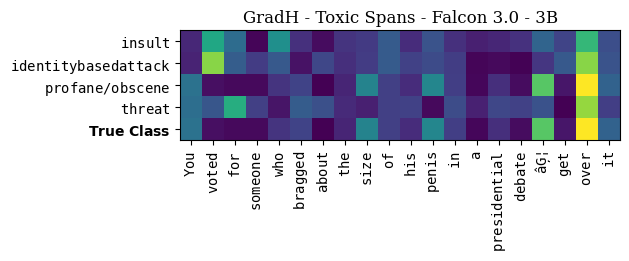

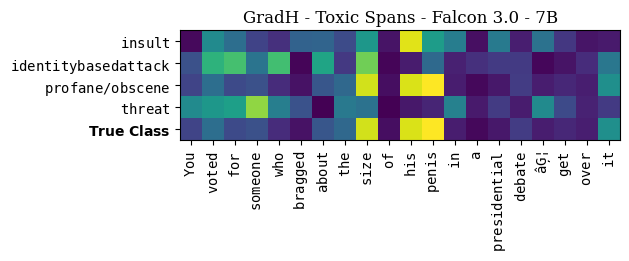

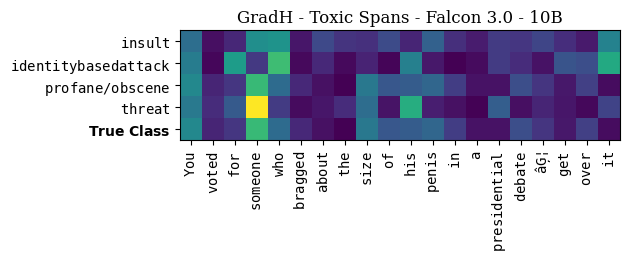

In [20]:
importance_gradh_raw = {model:[] for model in RESULTS}
importance_gradh_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']
    
        # get importance:
        importance = np.abs(r['GradH'][:, start:end])
    
        # per token in label:
        importance_gradh_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_gradh_cls[model].append(importance_gradh_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_gradh_raw, importance_gradh_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'GradH - Toxic Spans')
pearson.add(importance_gradh_cls, 'GradH')

# Grad$^{-1}$

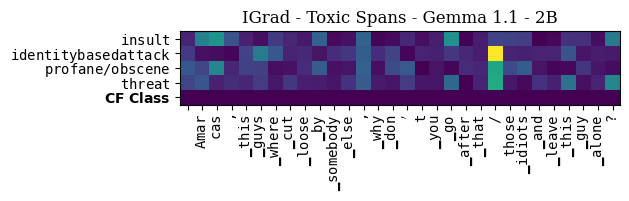

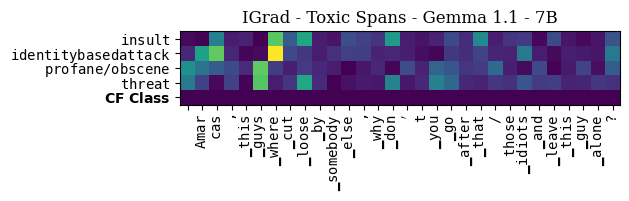

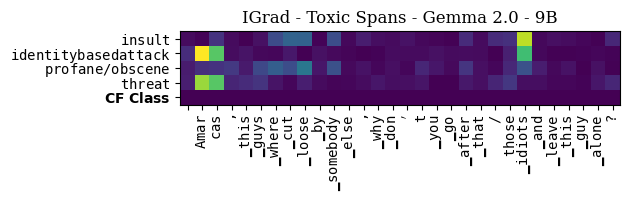

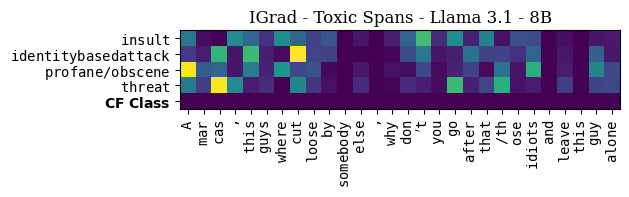

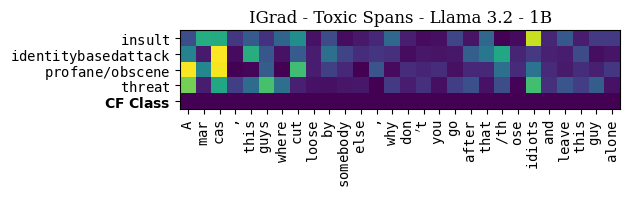

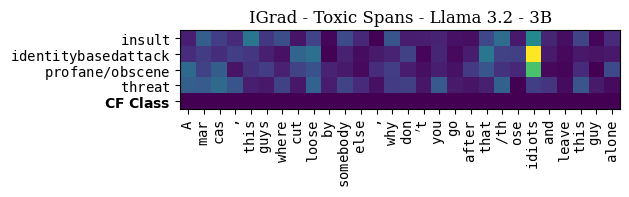

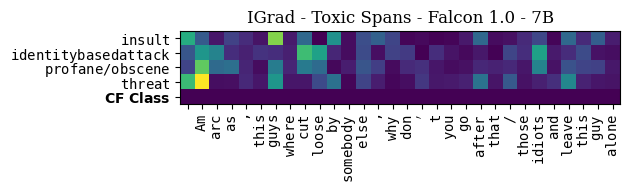

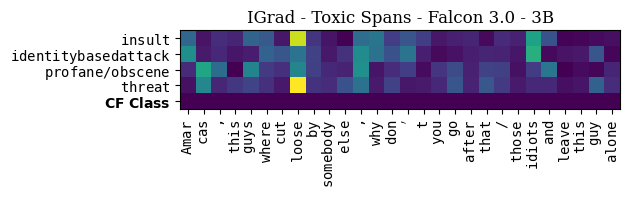

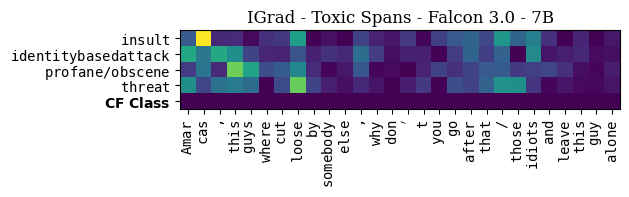

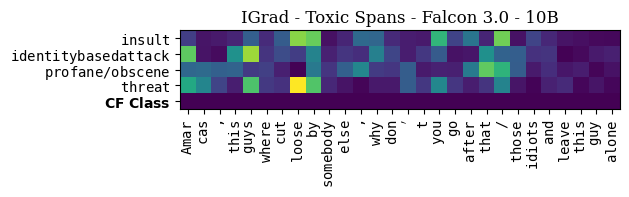

In [21]:
importance_igrad_raw = {model:[] for model in RESULTS}
importance_igrad_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']

        # get counterfactual label:
        cf    = r['counterfactual']['target_label']

        # get importance:
        importance = np.abs(r['IGrad'][:,start:end,:].mean(axis=-1))

        importance_igrad_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only counterfactual class:
        importance_igrad_cls[model].append(importance_igrad_raw[model][-1][cf])

#        # create counterfactual text:
#        original = np.zeros(importance.shape[1:], dtype=float)
#        for i, token in enumerate(r['tokens'][start:end]):
#            original[i, r['IGrad-tokens'][:1024].index(token)] = 1.
#
#        print(r['prediction']['text'], '->', cf, [r['IGrad-tokens'][i] for i in (original - importance[LABELS == cf][0]).argmax(axis=-1)])

plotter.plot_importance([importance_gradin_raw, importance_igrad_cls], ['', '$\\bf\u007bCF~Class\u007d$'], f'IGrad - Toxic Spans')
pearson.add(importance_igrad_cls, 'IGrad')

# Shap:

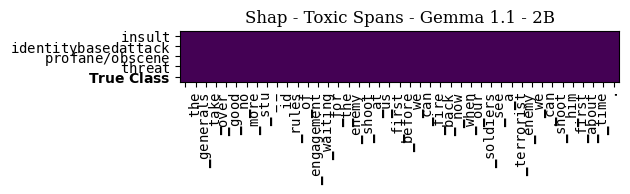

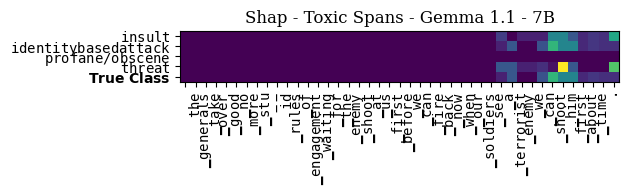

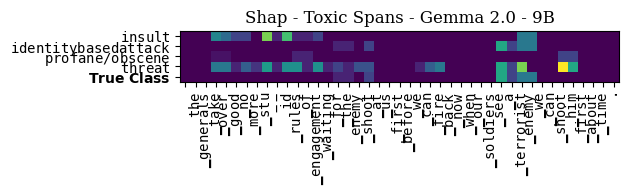

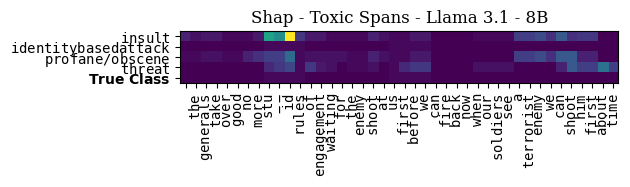

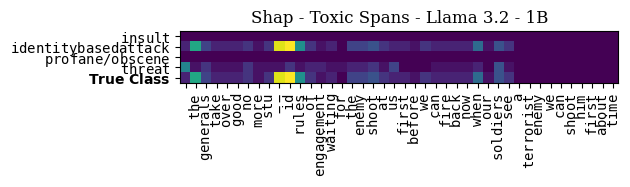

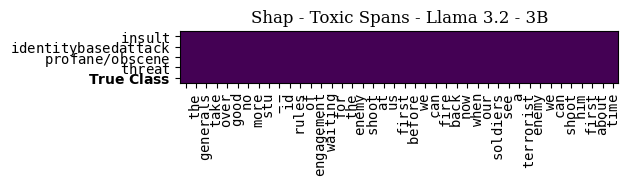

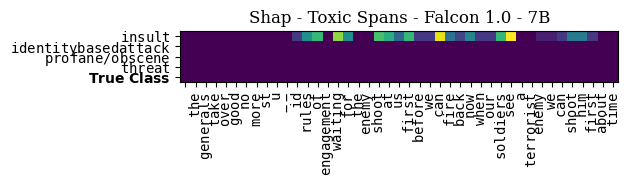

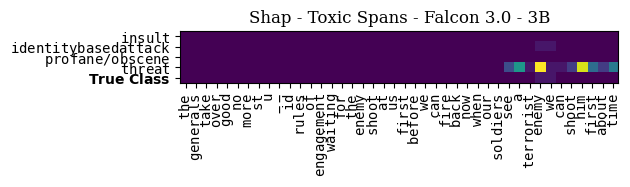

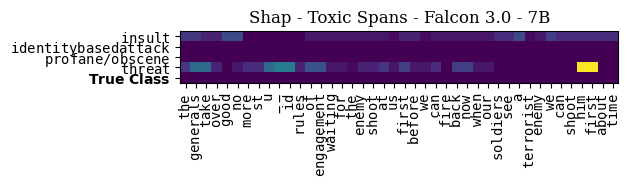

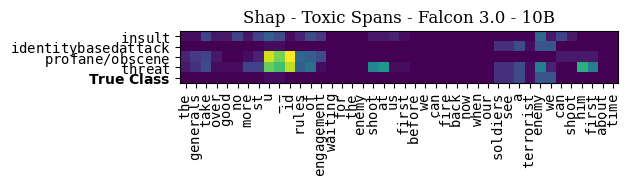

In [22]:
importance_shap_cls = {model:[] for model in RESULTS}
importance_shap_raw = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        if not 'Shap' in r: continue

        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']

        # get importance:
        importance = np.abs(r['Shap'][:, start:end])

        # per token in label:
        importance_shap_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_shap_cls[model].append(importance_shap_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_shap_raw, importance_shap_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'Shap - Toxic Spans')
pearson.add(importance_shap_cls, 'Shap')

/tmp/ipykernel_4071524/2109695417.py:1: RuntimeWarning: invalid value encountered in divide
  scale = lambda d: {key: [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in d[key]] for key in d}


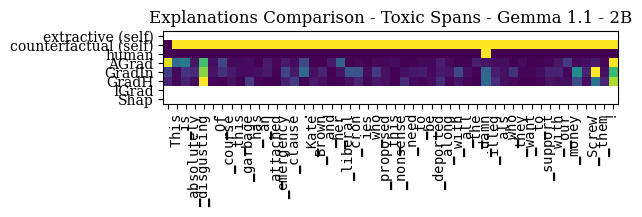

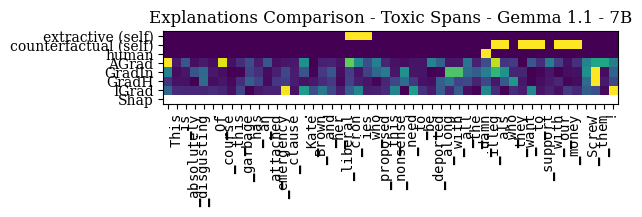

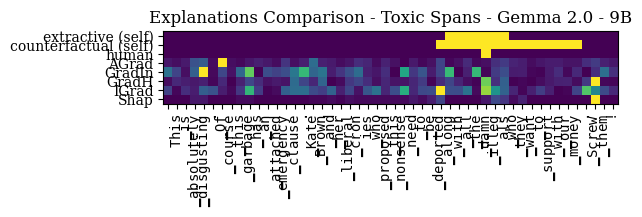

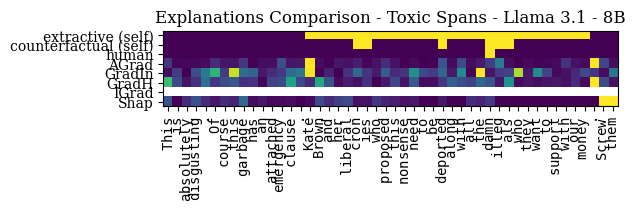

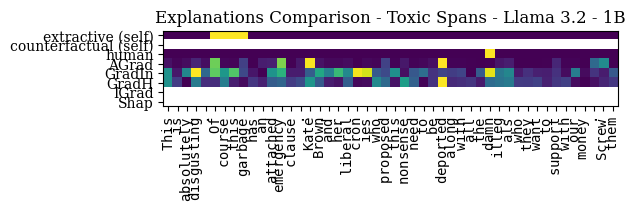

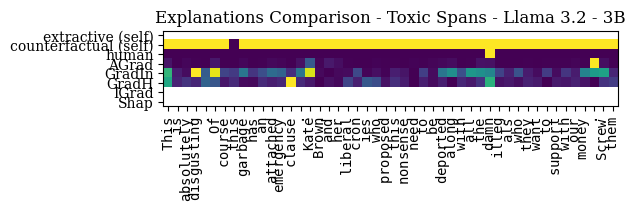

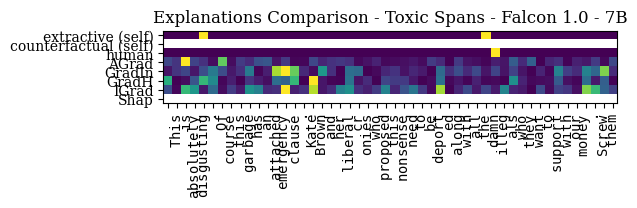

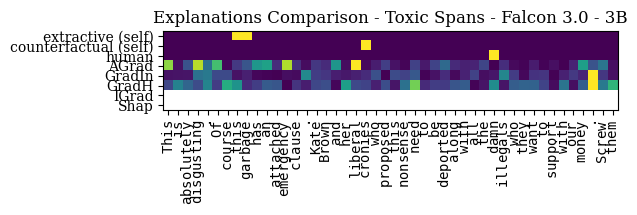

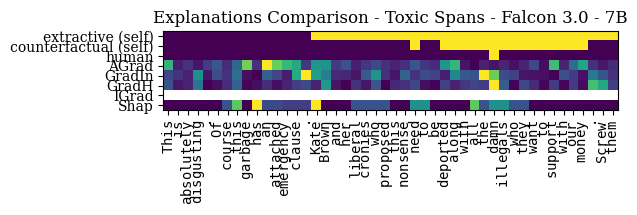

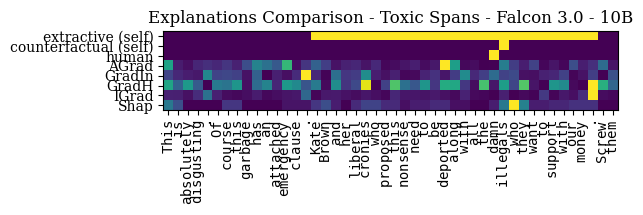

In [23]:
scale = lambda d: {key: [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in d[key]] for key in d}
plotter.plot_importance(
    [
        scale(importance_self),
        scale(importance_cf),
        scale(importance_human),
        scale(importance_agrad_cls),
        scale(importance_gradin_cls),
        scale(importance_gradh_cls),
        scale(importance_igrad_cls),
        scale(importance_shap_cls)
    ],
    ['extractive (self)', 'counterfactual (self)', 'human', 'AGrad', 'GradIn', 'GradH', 'IGrad', 'Shap'],
    f'Explanations Comparison - Toxic Spans'
)

# Correlations:

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


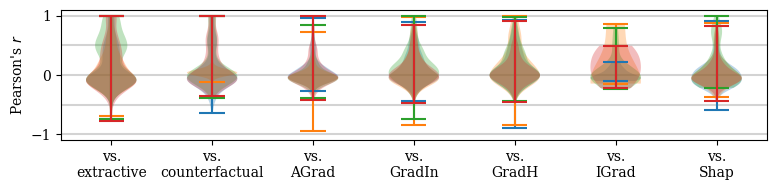

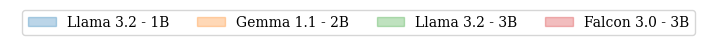

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


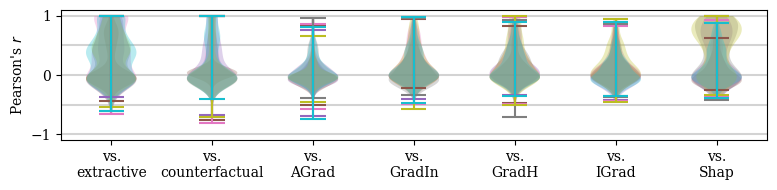

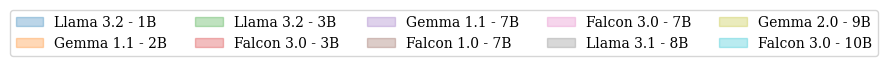

In [24]:
pearson.boxplot('human', path=f'{PLOTS_DIR}/PearsonViolin - Toxic Spans - Human.pdf')

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


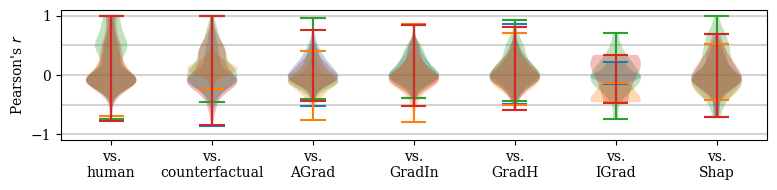

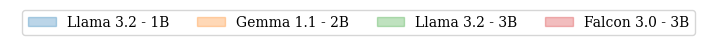

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


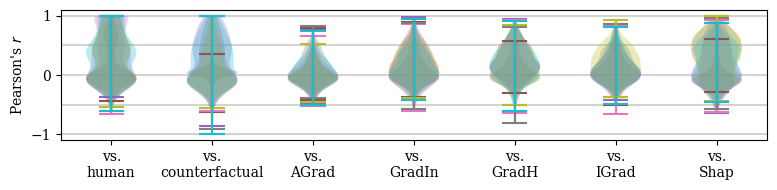

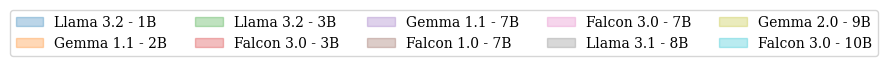

In [25]:
pearson.boxplot('extractive', path=f'{PLOTS_DIR}/PearsonViolin - Toxic Spans - Self.pdf')

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


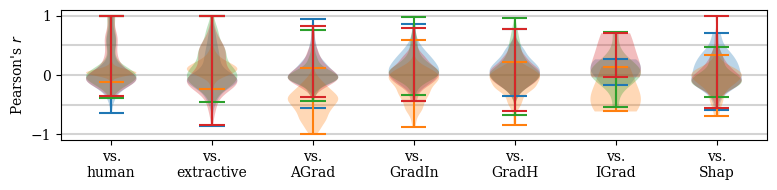

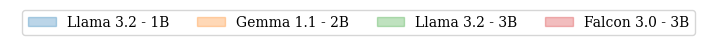

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


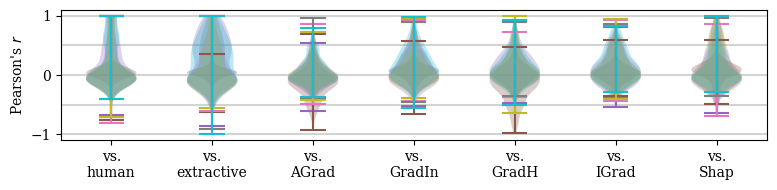

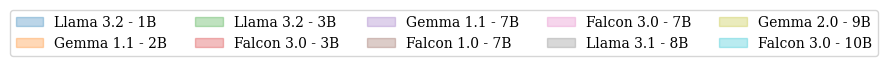

In [26]:
pearson.boxplot('counterfactual', path=f'{PLOTS_DIR}/PearsonViolin - Toxic Spans - Counterfactual.pdf')

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


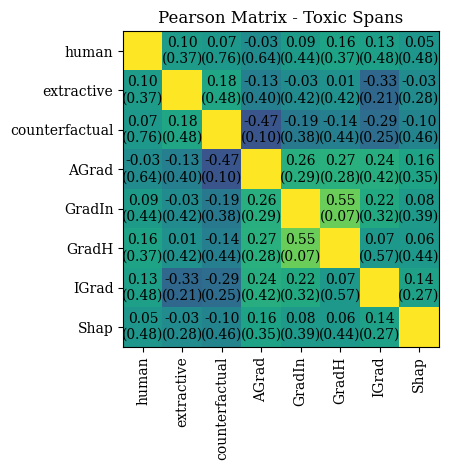

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


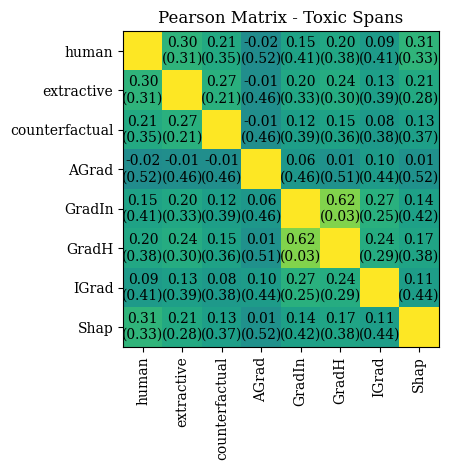

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


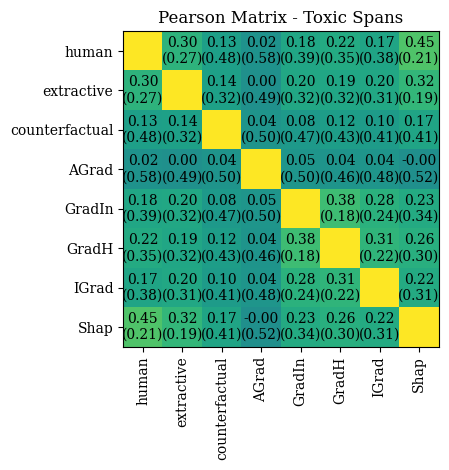

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


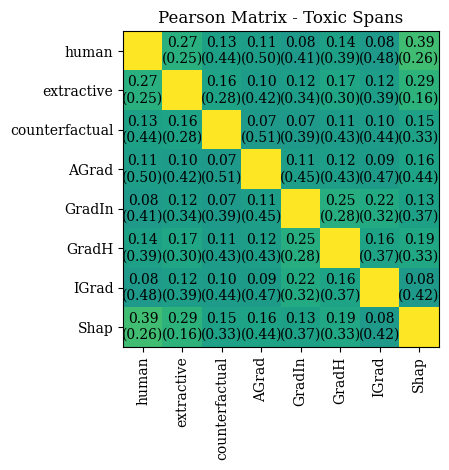

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


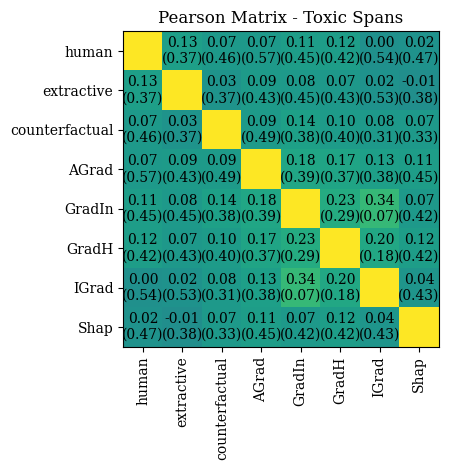

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


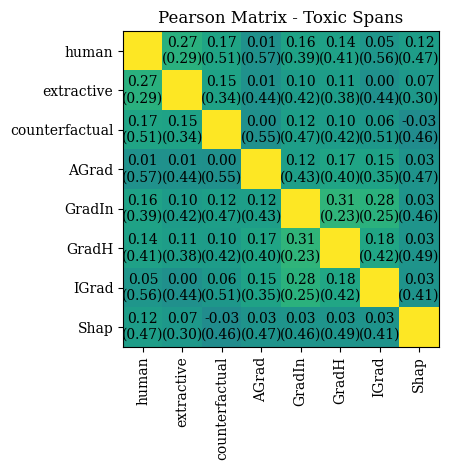

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


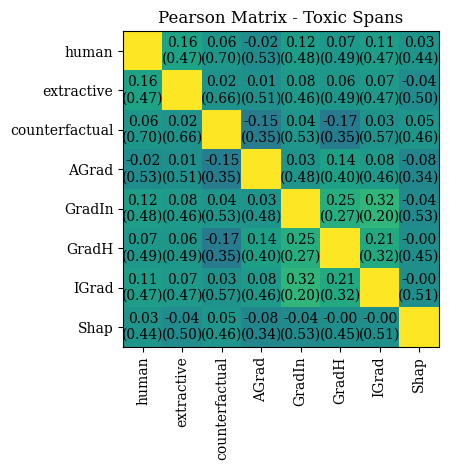

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


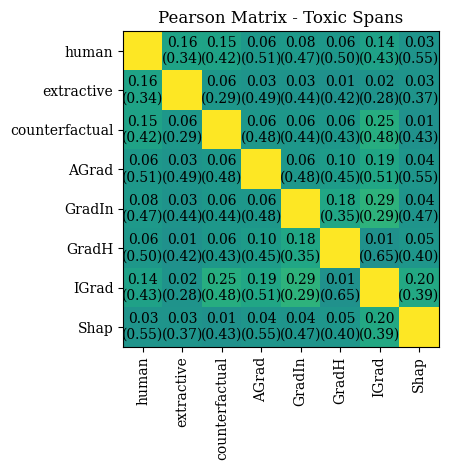

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


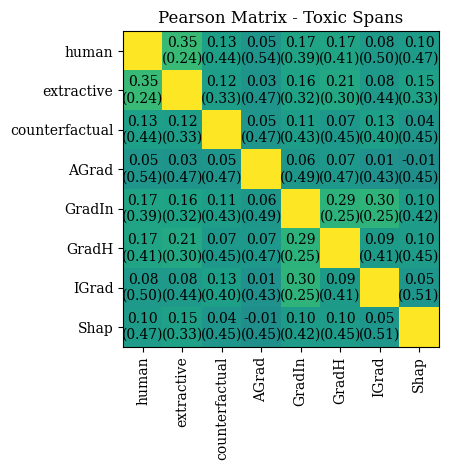

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


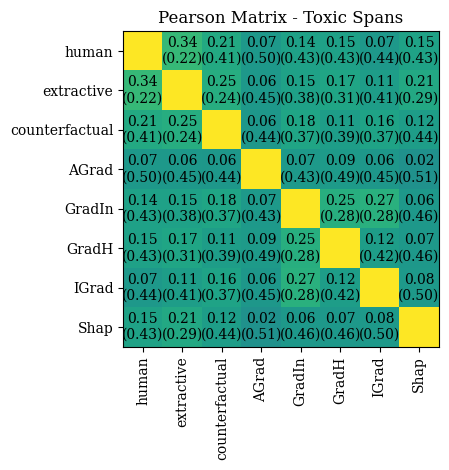

In [27]:
pearson.matrixplot(title='Pearson Matrix - Toxic Spans', dir=PLOTS_DIR)

# Counterfactual:

/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

Gemma 1.1 - 2B
  Success rate: 0.98
  Similarity: 0.7493307411975697
  BLEU: 0.027156777410311406
  ROUGE-1: 0.01825703698555351
  ROUGE-L: 0.025601392374017883
  BART: -6.396218149029479

Gemma 1.1 - 7B
  Success rate: 0.945
  Similarity: 0.9156678958925062
  BLEU: 0.7491358078079571
  ROUGE-1: 0.5896180026411567
  ROUGE-L: 0.7325988386339453
  BART: -2.169052992232893

Gemma 2.0 - 9B
  Success rate: 1.0
  Similarity: 0.9559344423201119
  BLEU: 0.8400291819326173
  ROUGE-1: 0.7345441064803989
  ROUGE-L: 0.8382681223916159
  BART: -2.0135691186785696

Llama 3.1 - 8B
  Success rate: 0.635
  Similarity: 0.9415588770481752
  BLEU: 0.8158204713057823
  ROUGE-1: 0.6976542623252526
  ROUGE-L: 0.8122097882008014
  BART: -1.9702407135738162

Llama 3.2 - 1B
  Success rate: 0.665
  Similarity: 0.9166999867932073
  BLEU: 0.8112160941230695
  ROUGE-1: 0.6923952640649581
  ROUGE-L: 0.7954930202361686
  BART: -1.9672333580210692

Llama 3.2 - 3B
  Success rate: 0.835
  Similarity: 0.8545038979118289


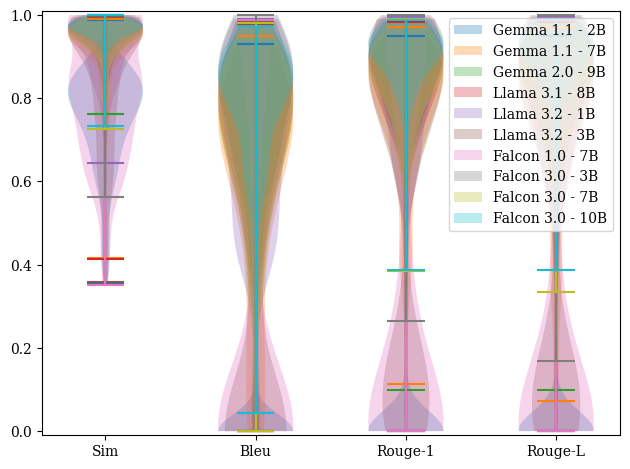

In [28]:
wp_tokenizer = WordPunctTokenizer()
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=wp_tokenizer)
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

hs, ls = [], [] 
for model in RESULTS:
    counterfactuals = []

    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']

        bleu = sentence_bleu([wp_tokenizer.tokenize(r['sample']['text'].lower())], wp_tokenizer.tokenize(cf['text'].lower()))
        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)

        counterfactuals.append((
            int(success),
            cf['similarity'],
            bleu,                      # bleu
            rouge['rouge1'].fmeasure,  # rouge
            rouge['rougeL'].fmeasure,
            bart[0]
        ))

    counterfactuals = np.array(counterfactuals, dtype=float)

    hs.append(plt.violinplot(counterfactuals[counterfactuals[:,0] == 1., 1:-1])['bodies'][0])
    ls.append(model)

    print(model)
    print('  Success rate:', counterfactuals[:,0].mean())
    print('  Similarity:', counterfactuals[counterfactuals[:,0] == 1., 1].mean())
    print('  BLEU:', counterfactuals[counterfactuals[:,0] == 1., 3].mean())
    print('  ROUGE-1:', counterfactuals[counterfactuals[:,0] == 1., 2].mean())
    print('  ROUGE-L:', counterfactuals[counterfactuals[:,0] == 1., 4].mean())
    print('  BART:', counterfactuals[counterfactuals[:,0] == 1., 5].mean())
    print()

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4], labels=['Sim', 'Bleu', 'Rouge-1', 'Rouge-L'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

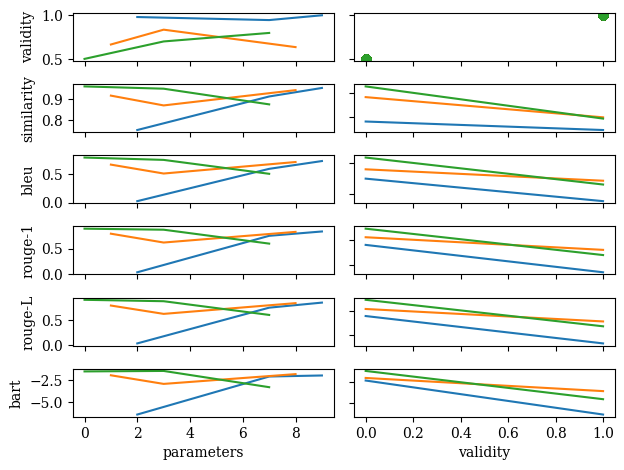

In [29]:
wp_tokenizer = WordPunctTokenizer()
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=wp_tokenizer)
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

counterfactuals = []
for model in RESULTS:
    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']

        bleu = sentence_bleu([wp_tokenizer.tokenize(r['sample']['text'].lower())], wp_tokenizer.tokenize(cf['text'].lower()))
        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)

        counterfactuals.append({
            'type':       model.split()[0].lower(),
            'parameters': int(model[-2]),
#            'depth':      r['hidden_states'].shape[1],
            'validity':   int(success),
            'similarity': cf['similarity'],
            'bleu':       bleu,
            'rouge-1':    rouge['rouge1'].fmeasure,
            'rouge-L':    rouge['rougeL'].fmeasure,
            'bart':       bart[0]
        })

counterfactuals = pd.DataFrame(counterfactuals)
columns_x = ['parameters', 'validity']
columns_y = ['validity', 'similarity', 'bleu', 'rouge-1', 'rouge-L', 'bart']

fig, axs = plt.subplots(len(columns_y), len(columns_x))
for i, x in enumerate(columns_x):
    for j, y in enumerate(columns_y):
        for tp in counterfactuals['type'].unique():
            values = counterfactuals[counterfactuals['type']==tp][[x, y]]

            if x != y:
                values = values.groupby(x).mean()
                axs[j,i].plot(values.index, values.values, label=tp)

            else: axs[j,i].scatter(values[x].values, values[y].values, label=tp)

        if j == len(columns_y)-1: axs[j,i].set_xlabel(x)
        else: axs[j,i].set_xticklabels([])

        if i == 0: axs[j,i].set_ylabel(y)
        else: axs[j,i].set_yticklabels([])

fig.tight_layout()
fig.show()